In [1]:
import tensorflow as tf
from tensorflow import keras

In [2]:
import numpy
import os 
import cv2
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet import preprocess_input
from keras import backend as K
import random
import pickle



In [3]:

import os
from pathlib import Path
root = os.getcwd() # Don't change this
data_dirname = '/data_test/plantvillage/' # Change as you like 
p = Path(root + data_dirname)
p.mkdir(exist_ok=True) # should "/content/gdrive/My Drive/data"


In [4]:
classes = ['Apple___Apple_scab','Apple___healthy']
for c in classes:
  print(c)
  filelist = [x for x in (p/c).iterdir() if x.is_file()]
  for f in filelist:
    img = cv2.imread(str(f))
    if img is None:
      print(f'Failed to open {f}. Deleting file')
      os.remove(str(f))

Apple___Apple_scab
Apple___healthy


In [5]:

# Pick first image of first class (i.e., cat)
filelist = [x for x in (p/classes[0]).iterdir() if x.is_file()]
img_path = filelist[1]
print(f"File path: {img_path}")

# Load image and preprocess it
img = load_img(img_path, target_size=(120, 120))
img_data = img_to_array(img, dtype = int)
img_data = np.expand_dims(img_data, axis=0)

File path: c:\Users\mwels\Documents\Uni\11. Semester\Deep learning in visual recognition\myawesome\data_test\plantvillage\Apple___Apple_scab\01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG


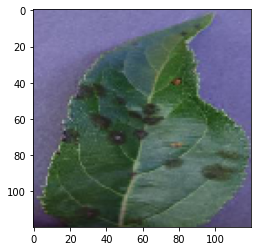

In [6]:
from cgitb import grey

plt.imshow(img_data[0])

In [7]:
img_data[0].shape

(120, 120, 3)

In [8]:
def getPermutation(image_array, tilenumberx=3, shuffle = True):
    """Takes an image as an array, and returns a permuted image as an array
    with corresponding labels.
    """
    idx = range(tilenumberx**2)
    if shuffle:
        idx = np.random.permutation(tilenumberx**2)
    tilesize_h = image_array.shape[0]//(tilenumberx)
    tilesize_w = image_array.shape[1]//(tilenumberx)
    #if len(image_array.shape) == 4:
    #    tiles = [np.array([image[(i//3)*tilesize_h:(i//3+1)*tilesize_h,(i%tilenumberx)*tilesize_w:(i%tilenumberx+1)*tilesize_w,:] for i in idx])for image in image_array]
    #else:
    #    tiles = [image_array[(i//3)*tilesize_h:(i//3+1)*tilesize_h,(i%tilenumberx)*tilesize_w:(i%tilenumberx+1)*tilesize_w,:] for i in idx]
    tiles = [image_array[(i//3)*tilesize_h:(i//3+1)*tilesize_h,(i%tilenumberx)*tilesize_w:(i%tilenumberx+1)*tilesize_w,:] for i in idx]
    out = np.array(tiles)
    

    return out, idx

In [9]:
def showPermImg(X, y):
    plt.figure(figsize=(3,3))
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(X[i])
        plt.xticks([]), plt.yticks([])
        plt.title(int(y[i]))

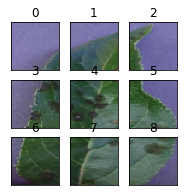

In [10]:
X, y = getPermutation(img_data[0], shuffle=False)
showPermImg(X,y)

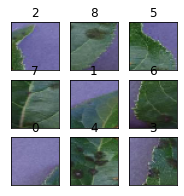

In [11]:
X, y = getPermutation(img_data[0])
showPermImg(X,y)

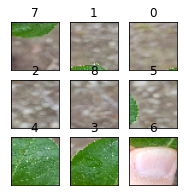

In [12]:
# Load image and preprocess it
img1 = load_img('data_test/Plantdoc/Apple_leaf_test/20180511_091252-1gy5xf5-e1526048000596.jpg', target_size=(120, 120))
img_data1 = img_to_array(img1, dtype = int)
showPermImg(*getPermutation(img_data1))

In [13]:
from keras.preprocessing.image import Iterator
from keras.utils.np_utils import to_categorical
import cv2

class PermNetDataGenerator(Iterator):

    def __init__(self, input, batch_size=64,
                 preprocess_func=None, shuffle=False):
        if type(input) == list:
            self.im_as_files = True
            self.input_shape = (9,40,40,3) #should prob not be harcoded
        else:
            self.input_shape = self.images.shape[1:]
        self.images = input
        self.batch_size = batch_size
        self.preprocess_func = preprocess_func
        self.shuffle = shuffle
        self.n = len(input)

        # add dimension if the images are greyscale
        if len(self.input_shape) == 2:
            self.input_shape = self.input_shape + (1,)
        N = len(self.images)

        super(PermNetDataGenerator, self).__init__(N, batch_size, shuffle, None)
        
    def _get_batches_of_transformed_samples(self, index_array):
        # create array to hold the images
        batch_x = np.zeros((len(index_array),) + self.input_shape, dtype='float32')
        # create array to hold the labels
        batch_y = np.zeros((len(index_array),9), dtype='float32')

        # iterate through the current batch
        for i, j in enumerate(index_array):
            
            if self.im_as_files:
                image = img_to_array(load_img(self.images[j], target_size=(120, 120))) / 255 #should prob not be hardcoded
            else:
                image = self.images[j].squeeze()
            X, y = getPermutation(image)
            # store the image and label in their corresponding batches
            batch_x[i] = X
            batch_y[i] = y

        # preprocess input images
        if self.preprocess_func:
            batch_x = self.preprocess_func(batch_x)

        return batch_x, batch_y

    def next(self):
        with self.lock:
            # get input data index and size of the current batch
            index_array = next(self.index_generator)
        # create array to hold the images
        return self._get_batches_of_transformed_samples(index_array)


(16, 9, 40, 40, 3) (16, 9)


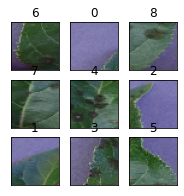

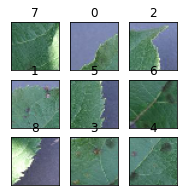

In [14]:
datagenPerm = PermNetDataGenerator(filelist, 16)
X, y = datagenPerm.next()
print(X.shape, y.shape)
showPermImg(X[1],y[1])
showPermImg(X[2],y[2])

In [15]:
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(120, 120, 3))

In [16]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)
gen_path = p
train_generator = datagen.flow_from_directory(str(gen_path),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='training')
validation_generator = datagen.flow_from_directory(str(gen_path),
                                        target_size=(120,120),
                                        color_mode='rgb',
                                        batch_size=8,
                                        class_mode='categorical',
                                        shuffle=True,
                                        subset='validation')

Found 2537 images belonging to 4 classes.
Found 634 images belonging to 4 classes.


In [17]:
from keras.layers import Dense,GlobalAveragePooling2D
from keras.models import Model

# Add new top layer
N = 4
x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation='relu')(x) #dense layer
preds = Dense(N,activation='softmax')(x) #final layer with softmax activation

# Specify model
model = Model(inputs=conv_base.input, outputs=preds)

In [18]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 89
Number of pretrained base layers is 86


In [19]:
from keras import optimizers

# Set up optimizer
sgd_optimizer = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='binary_crossentropy',metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 10 epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=5)

Epoch 1/5


c:\Users\mwels\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
C:\Users\mwels\AppData\Local\Temp\ipykernel_6500\2694328886.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


110/317 [=========>....................] - ETA: 20s - loss: 0.3045 - accuracy: 0.7716

KeyboardInterrupt: 

In [ ]:
model.save("models/2022_09_29__01")

INFO:tensorflow:Assets written to: models/2022_09_29__01/assets


INFO:tensorflow:Assets written to: models/2022_09_29__01/assets


In [20]:
conv_base = MobileNet(weights='imagenet',
                      include_top=False,
                      input_shape=(40, 40, 3))
type(conv_base)


keras.engine.functional.Functional

In [21]:
from keras.layers import Dense,GlobalAveragePooling2D, Concatenate, Input, Flatten
from keras.models import Model


number_of_tiles = 9
image_net = conv_base
tile1 = Input((40,40,3))
tile2 = Input((40,40,3))
tile3 = Input((40,40,3))
tile4 = Input((40,40,3))
tile5 = Input((40,40,3))
tile6 = Input((40,40,3))
tile7 = Input((40,40,3))
tile8 = Input((40,40,3))
tile9 = Input((40,40,3))

embedding_of_tile1 = image_net(tile1) 
embedding_of_tile2 = image_net(tile2)
embedding_of_tile3 = image_net(tile3) 
embedding_of_tile4 = image_net(tile4) 
embedding_of_tile5 = image_net(tile5) 
embedding_of_tile6 = image_net(tile6)
embedding_of_tile7 = image_net(tile7)
embedding_of_tile8 = image_net(tile8)
embedding_of_tile9 = image_net(tile9)

concatonation = Concatenate(axis=1)([
    embedding_of_tile1,
    embedding_of_tile2,
    embedding_of_tile3,
    embedding_of_tile4,
    embedding_of_tile5,
    embedding_of_tile6,
    embedding_of_tile7,
    embedding_of_tile8,
    embedding_of_tile9
    ])
out = Dense(1, activation="tanh")(concatonation)
out = Flatten()(out)

# Specify model
model = Model(inputs=[tile1, tile2, tile3, tile4, tile5, tile6, tile7, tile8, tile9], outputs=out)

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 40, 40, 3)]  0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 40, 40, 3)]  0           []                               
                                                                                            

In [23]:
total_num_layers = len(model.layers)
num_base_layers = len(conv_base.layers)
print(f"Total number of layers is {total_num_layers}")
print(f"Number of pretrained base layers is {num_base_layers}")

for layer in model.layers[:num_base_layers]:
    layer.trainable=False
for layer in model.layers[num_base_layers:]:
    layer.trainable=True

Total number of layers is 13
Number of pretrained base layers is 86


In [28]:

from isort import file
from keras import optimizers
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(filelist)

train_generator = PermNetDataGenerator(x_train, 16)
validation_generator = PermNetDataGenerator(x_test, 16)


# Set up optimizer
sgd_optimizer = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

# Compile model - make it trainable
model.compile(optimizer=sgd_optimizer,loss='binary_crossentropy',metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size # Number of mini-batches per epoch (training)
step_size_val = validation_generator.n//validation_generator.batch_size # Number of mini-batches per epoch (validation)

# Train model for 10 epochs
history = model.fit_generator(generator=train_generator,
                   validation_data=validation_generator,
                   validation_steps=step_size_val,
                   steps_per_epoch=step_size_train,
                   epochs=5)

C:\Users\mwels\AppData\Local\Temp\ipykernel_6500\1774256659.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator,


Epoch 1/5


ValueError: in user code:

    File "c:\Users\mwels\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\mwels\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\mwels\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\mwels\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\mwels\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\mwels\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_1" expects 9 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None, None) dtype=float32>]


In [ ]:
print(len(x_train))
print(len(x_test))
print(len(filelist))

472
158
630


In [29]:
train_gen = PermNetDataGenerator(x_train, 16)

In [32]:
model(next(train_gen))

ValueError: Layer "model_1" expects 9 input(s), but it received 2 input tensors. Inputs received: [<tf.Tensor: shape=(16, 9, 40, 40, 3), dtype=float32, numpy=
array([[[[[0.69803923, 0.6666667 , 0.7490196 ],
          [0.69411767, 0.6627451 , 0.74509805],
          [0.70980394, 0.6784314 , 0.7607843 ],
          ...,
          [0.16470589, 0.3137255 , 0.08235294],
          [0.29411766, 0.4509804 , 0.20784314],
          [0.19607843, 0.3529412 , 0.10588235]],

         [[0.85490197, 0.8235294 , 0.90588236],
          [0.6862745 , 0.654902  , 0.7372549 ],
          [0.61960787, 0.5882353 , 0.67058825],
          ...,
          [0.2       , 0.36078432, 0.09411765],
          [0.2784314 , 0.4392157 , 0.17254902],
          [0.23137255, 0.39607844, 0.13725491]],

         [[0.64705884, 0.6156863 , 0.69803923],
          [0.7176471 , 0.6862745 , 0.76862746],
          [0.69411767, 0.6627451 , 0.74509805],
          ...,
          [0.44313726, 0.60784316, 0.31764707],
          [0.34901962, 0.5137255 , 0.23137255],
          [0.14901961, 0.31764707, 0.03921569]],

         ...,

         [[0.6117647 , 0.5803922 , 0.6627451 ],
          [0.63529414, 0.6039216 , 0.6862745 ],
          [0.6745098 , 0.6431373 , 0.7254902 ],
          ...,
          [0.4       , 0.54901963, 0.3647059 ],
          [0.27058825, 0.41960785, 0.22745098],
          [0.2901961 , 0.44313726, 0.23529412]],

         [[0.7372549 , 0.7058824 , 0.7882353 ],
          [0.75686276, 0.7254902 , 0.80784315],
          [0.64705884, 0.6156863 , 0.69803923],
          ...,
          [0.3137255 , 0.4627451 , 0.27058825],
          [0.28627452, 0.43529412, 0.23529412],
          [0.22352941, 0.3764706 , 0.16078432]],

         [[0.60784316, 0.5764706 , 0.65882355],
          [0.65882355, 0.627451  , 0.70980394],
          [0.6666667 , 0.63529414, 0.7176471 ],
          ...,
          [0.30980393, 0.45882353, 0.25882354],
          [0.3647059 , 0.5176471 , 0.30980393],
          [0.31764707, 0.47058824, 0.25490198]]],


        [[[0.29803923, 0.44313726, 0.23921569],
          [0.2901961 , 0.43529412, 0.22352941],
          [0.4392157 , 0.54901963, 0.3882353 ],
          ...,
          [0.28235295, 0.39607844, 0.14509805],
          [0.23921569, 0.3529412 , 0.10196079],
          [0.44313726, 0.54509807, 0.29803923]],

         [[0.5019608 , 0.6039216 , 0.4509804 ],
          [0.34509805, 0.44313726, 0.28627452],
          [0.3764706 , 0.4745098 , 0.30980393],
          ...,
          [0.21568628, 0.29803923, 0.07843138],
          [0.34509805, 0.41568628, 0.21176471],
          [0.32156864, 0.3882353 , 0.18431373]],

         [[0.4509804 , 0.54901963, 0.39215687],
          [0.5529412 , 0.61960787, 0.49411765],
          [0.53333336, 0.6117647 , 0.5058824 ],
          ...,
          [0.14509805, 0.21960784, 0.03921569],
          [0.11764706, 0.16862746, 0.        ],
          [0.20784314, 0.21568628, 0.0627451 ]],

         ...,

         [[0.19215687, 0.3529412 , 0.11764706],
          [0.19607843, 0.34117648, 0.12941177],
          [0.1882353 , 0.34509805, 0.10196079],
          ...,
          [0.03921569, 0.03921569, 0.04705882],
          [0.03921569, 0.03921569, 0.04705882],
          [0.03921569, 0.03921569, 0.04705882]],

         [[0.18039216, 0.3529412 , 0.10588235],
          [0.1764706 , 0.33333334, 0.09803922],
          [0.22352941, 0.34509805, 0.10980392],
          ...,
          [0.03921569, 0.03921569, 0.04705882],
          [0.03921569, 0.03921569, 0.04705882],
          [0.03921569, 0.03921569, 0.04705882]],

         [[0.18431373, 0.36078432, 0.09803922],
          [0.22352941, 0.38039216, 0.13333334],
          [0.26666668, 0.36078432, 0.13333334],
          ...,
          [0.03921569, 0.03921569, 0.04705882],
          [0.03921569, 0.03921569, 0.04705882],
          [0.03921569, 0.03921569, 0.04705882]]],


        [[[0.39607844, 0.49411765, 0.32941177],
          [0.49411765, 0.59607846, 0.41960785],
          [0.44705883, 0.5686275 , 0.34509805],
          ...,
          [0.7176471 , 0.6666667 , 0.7372549 ],
          [0.54901963, 0.49803922, 0.5686275 ],
          [0.6862745 , 0.63529414, 0.7058824 ]],

         [[0.56078434, 0.6862745 , 0.5019608 ],
          [0.5372549 , 0.6627451 , 0.47843137],
          [0.62352943, 0.7411765 , 0.5294118 ],
          ...,
          [0.85882354, 0.80784315, 0.8784314 ],
          [0.77254903, 0.72156864, 0.7921569 ],
          [0.64705884, 0.59607846, 0.6666667 ]],

         [[0.37254903, 0.5058824 , 0.30980393],
          [0.41568628, 0.54901963, 0.3529412 ],
          [0.38431373, 0.49411765, 0.29411766],
          ...,
          [0.75686276, 0.7058824 , 0.7764706 ],
          [0.79607844, 0.74509805, 0.8156863 ],
          [0.58431375, 0.53333336, 0.6039216 ]],

         ...,

         [[0.34901962, 0.39215687, 0.26666668],
          [0.61960787, 0.7019608 , 0.5411765 ],
          [0.38431373, 0.5058824 , 0.33333334],
          ...,
          [0.22352941, 0.36862746, 0.09803922],
          [0.23529412, 0.37254903, 0.10588235],
          [0.31764707, 0.45882353, 0.18431373]],

         [[0.4392157 , 0.52156866, 0.36862746],
          [0.36862746, 0.47058824, 0.28627452],
          [0.34117648, 0.47843137, 0.3137255 ],
          ...,
          [0.23529412, 0.38039216, 0.10588235],
          [0.23921569, 0.3882353 , 0.10196079],
          [0.5882353 , 0.7372549 , 0.44313726]],

         [[0.4392157 , 0.5647059 , 0.36862746],
          [0.45882353, 0.59607846, 0.3764706 ],
          [0.40784314, 0.53333336, 0.37254903],
          ...,
          [0.2901961 , 0.43137255, 0.15686275],
          [0.4862745 , 0.627451  , 0.34509805],
          [0.3647059 , 0.5058824 , 0.22352941]]],


        ...,


        [[[0.58431375, 0.5647059 , 0.6431373 ],
          [0.6784314 , 0.65882355, 0.7372549 ],
          [0.74509805, 0.7254902 , 0.8039216 ],
          ...,
          [0.8039216 , 0.7882353 , 0.85490197],
          [0.62352943, 0.60784316, 0.6745098 ],
          [0.67058825, 0.654902  , 0.72156864]],

         [[0.6862745 , 0.6666667 , 0.74509805],
          [0.6509804 , 0.6313726 , 0.70980394],
          [0.7137255 , 0.69411767, 0.77254903],
          ...,
          [0.7647059 , 0.7490196 , 0.8156863 ],
          [0.72156864, 0.7058824 , 0.77254903],
          [0.5921569 , 0.5764706 , 0.6431373 ]],

         [[0.78039217, 0.7607843 , 0.8392157 ],
          [0.6039216 , 0.58431375, 0.6627451 ],
          [0.57254905, 0.5529412 , 0.6313726 ],
          ...,
          [0.7019608 , 0.6745098 , 0.74509805],
          [0.75686276, 0.7294118 , 0.8       ],
          [0.7764706 , 0.7490196 , 0.81960785]],

         ...,

         [[0.65882355, 0.627451  , 0.70980394],
          [0.64705884, 0.6156863 , 0.69803923],
          [0.65882355, 0.627451  , 0.70980394],
          ...,
          [0.2509804 , 0.34901962, 0.18431373],
          [0.31764707, 0.42745098, 0.23921569],
          [0.32156864, 0.43529412, 0.22352941]],

         [[0.7019608 , 0.67058825, 0.7529412 ],
          [0.5921569 , 0.56078434, 0.6431373 ],
          [0.5803922 , 0.54901963, 0.6313726 ],
          ...,
          [0.15294118, 0.25882354, 0.08235294],
          [0.28627452, 0.4       , 0.21176471],
          [0.29411766, 0.4117647 , 0.2       ]],

         [[0.64705884, 0.6156863 , 0.69803923],
          [0.6313726 , 0.6       , 0.68235296],
          [0.62352943, 0.5921569 , 0.6745098 ],
          ...,
          [0.21960784, 0.34509805, 0.14901961],
          [0.25882354, 0.39607844, 0.18431373],
          [0.20392157, 0.34117648, 0.11372549]]],


        [[[0.6745098 , 0.65882355, 0.7254902 ],
          [0.6039216 , 0.5882353 , 0.654902  ],
          [0.61960787, 0.6039216 , 0.67058825],
          ...,
          [0.5137255 , 0.47843137, 0.54509807],
          [0.6156863 , 0.5803922 , 0.64705884],
          [0.64705884, 0.6117647 , 0.6784314 ]],

         [[0.7137255 , 0.69803923, 0.7647059 ],
          [0.5803922 , 0.5647059 , 0.6313726 ],
          [0.7490196 , 0.73333335, 0.8       ],
          ...,
          [0.64705884, 0.6117647 , 0.6784314 ],
          [0.75686276, 0.72156864, 0.7882353 ],
          [0.49411765, 0.45882353, 0.5254902 ]],

         [[0.47058824, 0.44313726, 0.5137255 ],
          [0.68235296, 0.654902  , 0.7254902 ],
          [0.5921569 , 0.5647059 , 0.63529414],
          ...,
          [0.5686275 , 0.53333336, 0.6       ],
          [0.6039216 , 0.5686275 , 0.63529414],
          [0.8       , 0.7647059 , 0.83137256]],

         ...,

         [[0.28235295, 0.40392157, 0.16862746],
          [0.39215687, 0.5176471 , 0.27058825],
          [0.26666668, 0.40392157, 0.15294118],
          ...,
          [0.44705883, 0.50980395, 0.36862746],
          [0.3647059 , 0.41960785, 0.28235295],
          [0.4392157 , 0.4862745 , 0.34509805]],

         [[0.24705882, 0.38039216, 0.14117648],
          [0.23137255, 0.36862746, 0.11764706],
          [0.14509805, 0.28627452, 0.03529412],
          ...,
          [0.40784314, 0.4745098 , 0.33333334],
          [0.36078432, 0.42352942, 0.28235295],
          [0.38039216, 0.43529412, 0.29411766]],

         [[0.43137255, 0.58431375, 0.3372549 ],
          [0.28235295, 0.43529412, 0.18039216],
          [0.20392157, 0.3647059 , 0.10588235],
          ...,
          [0.3529412 , 0.4392157 , 0.2901961 ],
          [0.27058825, 0.35686275, 0.20392157],
          [0.2       , 0.28235295, 0.12941177]]],


        [[[0.29803923, 0.45490196, 0.20784314],
          [0.21568628, 0.38039216, 0.12156863],
          [0.15686275, 0.33333334, 0.07058824],
          ...,
          [0.42745098, 0.53333336, 0.37254903],
          [0.44313726, 0.54901963, 0.3882353 ],
          [0.34117648, 0.44705883, 0.2784314 ]],

         [[0.23137255, 0.39607844, 0.13725491],
          [0.4862745 , 0.6627451 , 0.4       ],
          [0.2       , 0.38431373, 0.11764706],
          ...,
          [0.4117647 , 0.52156866, 0.36078432],
          [0.50980395, 0.62352943, 0.4509804 ],
          [0.5411765 , 0.654902  , 0.48235294]],

         [[0.27058825, 0.43529412, 0.1764706 ],
          [0.17254902, 0.34901962, 0.08627451],
          [0.18431373, 0.36078432, 0.09803922],
          ...,
          [0.4862745 , 0.6       , 0.42745098],
          [0.3254902 , 0.44705883, 0.27450982],
          [0.4117647 , 0.5372549 , 0.3529412 ]],

         ...,

         [[0.2627451 , 0.41568628, 0.2       ],
          [0.34901962, 0.5019608 , 0.2784314 ],
          [0.33333334, 0.4862745 , 0.27058825],
          ...,
          [0.30588236, 0.30980393, 0.25490198],
          [0.2509804 , 0.24313726, 0.18431373],
          [0.34117648, 0.35686275, 0.26666668]],

         [[0.32941177, 0.48235294, 0.25882354],
          [0.2901961 , 0.44313726, 0.21960784],
          [0.3254902 , 0.47843137, 0.2627451 ],
          ...,
          [0.38431373, 0.43529412, 0.33333334],
          [0.3372549 , 0.3882353 , 0.2784314 ],
          [0.4509804 , 0.50980395, 0.38039216]],

         [[0.3529412 , 0.5058824 , 0.28235295],
          [0.2901961 , 0.44705883, 0.21176471],
          [0.4       , 0.5529412 , 0.32941177],
          ...,
          [0.3529412 , 0.46666667, 0.28627452],
          [0.3764706 , 0.49019608, 0.31764707],
          [0.41960785, 0.53333336, 0.3529412 ]]]],



       [[[[0.3137255 , 0.41960785, 0.29803923],
          [0.33333334, 0.43137255, 0.3137255 ],
          [0.2784314 , 0.33333334, 0.27450982],
          ...,
          [0.52156866, 0.54509807, 0.6862745 ],
          [0.5254902 , 0.54901963, 0.6901961 ],
          [0.49019608, 0.5137255 , 0.654902  ]],

         [[0.2       , 0.2784314 , 0.17254902],
          [0.22745098, 0.30588236, 0.20784314],
          [0.22745098, 0.26666668, 0.22352941],
          ...,
          [0.5019608 , 0.5254902 , 0.6666667 ],
          [0.48235294, 0.5058824 , 0.64705884],
          [0.5019608 , 0.5254902 , 0.6666667 ]],

         [[0.21568628, 0.2627451 , 0.18431373],
          [0.21568628, 0.26666668, 0.19607843],
          [0.18039216, 0.2       , 0.1764706 ],
          ...,
          [0.5294118 , 0.5529412 , 0.69411767],
          [0.5294118 , 0.5529412 , 0.69411767],
          [0.54509807, 0.5686275 , 0.70980394]],

         ...,

         [[0.1764706 , 0.22352941, 0.16862746],
          [0.2       , 0.24313726, 0.1882353 ],
          [0.30980393, 0.41568628, 0.29411766],
          ...,
          [0.4745098 , 0.4745098 , 0.62352943],
          [0.4627451 , 0.4627451 , 0.6117647 ],
          [0.39215687, 0.39215687, 0.5411765 ]],

         [[0.13333334, 0.17254902, 0.12941177],
          [0.14117648, 0.19215687, 0.1254902 ],
          [0.20392157, 0.3254902 , 0.19215687],
          ...,
          [0.47843137, 0.47843137, 0.61960787],
          [0.47843137, 0.47843137, 0.61960787],
          [0.44313726, 0.44313726, 0.58431375]],

         [[0.15686275, 0.20392157, 0.14901961],
          [0.18039216, 0.23921569, 0.15686275],
          [0.2       , 0.33333334, 0.19607843],
          ...,
          [0.48235294, 0.48235294, 0.62352943],
          [0.4392157 , 0.4392157 , 0.5803922 ],
          [0.4392157 , 0.4392157 , 0.5803922 ]]],


        [[[0.22352941, 0.2901961 , 0.21568628],
          [0.28627452, 0.3764706 , 0.26666668],
          [0.30980393, 0.44313726, 0.30588236],
          ...,
          [0.5019608 , 0.5019608 , 0.63529414],
          [0.39215687, 0.39215687, 0.5254902 ],
          [0.43137255, 0.43137255, 0.5647059 ]],

         [[0.23137255, 0.31764707, 0.22745098],
          [0.26666668, 0.38431373, 0.24313726],
          [0.34509805, 0.47058824, 0.3254902 ],
          ...,
          [0.40392157, 0.40392157, 0.5372549 ],
          [0.3882353 , 0.3882353 , 0.52156866],
          [0.4509804 , 0.4509804 , 0.58431375]],

         [[0.3254902 , 0.4745098 , 0.3137255 ],
          [0.34117648, 0.48235294, 0.34117648],
          [0.3254902 , 0.42745098, 0.32156864],
          ...,
          [0.49019608, 0.49019608, 0.6313726 ],
          [0.48235294, 0.48235294, 0.62352943],
          [0.41960785, 0.41960785, 0.56078434]],

         ...,

         [[0.25490198, 0.24313726, 0.35686275],
          [0.28627452, 0.27450982, 0.39607844],
          [0.2901961 , 0.28627452, 0.40784314],
          ...,
          [0.38431373, 0.38431373, 0.5176471 ],
          [0.36078432, 0.36078432, 0.49411765],
          [0.34901962, 0.34901962, 0.48235294]],

         [[0.23529412, 0.22352941, 0.34509805],
          [0.2       , 0.1882353 , 0.30980393],
          [0.33333334, 0.32941177, 0.4509804 ],
          ...,
          [0.3882353 , 0.3882353 , 0.52156866],
          [0.36862746, 0.36862746, 0.5019608 ],
          [0.41960785, 0.41960785, 0.5529412 ]],

         [[0.2509804 , 0.23921569, 0.36078432],
          [0.3254902 , 0.3137255 , 0.43529412],
          [0.2784314 , 0.27450982, 0.4       ],
          ...,
          [0.36862746, 0.36862746, 0.5019608 ],
          [0.36078432, 0.36078432, 0.49411765],
          [0.3764706 , 0.3764706 , 0.50980395]]],


        [[[0.5411765 , 0.5411765 , 0.6901961 ],
          [0.5372549 , 0.5372549 , 0.6862745 ],
          [0.5294118 , 0.5294118 , 0.6784314 ],
          ...,
          [0.3372549 , 0.38431373, 0.29803923],
          [0.26666668, 0.31764707, 0.21568628],
          [0.28627452, 0.34509805, 0.22352941]],

         [[0.5372549 , 0.5372549 , 0.6862745 ],
          [0.54509807, 0.54509807, 0.69411767],
          [0.5254902 , 0.5254902 , 0.6745098 ],
          ...,
          [0.3647059 , 0.4117647 , 0.3254902 ],
          [0.4509804 , 0.5058824 , 0.40392157],
          [0.26666668, 0.3254902 , 0.20392157]],

         [[0.5176471 , 0.5176471 , 0.6666667 ],
          [0.5294118 , 0.5294118 , 0.6784314 ],
          [0.52156866, 0.52156866, 0.67058825],
          ...,
          [0.36862746, 0.42745098, 0.3372549 ],
          [0.2784314 , 0.34117648, 0.23529412],
          [0.3764706 , 0.44313726, 0.31764707]],

         ...,

         [[0.42352942, 0.42352942, 0.5647059 ],
          [0.40392157, 0.40392157, 0.54509807],
          [0.44705883, 0.44705883, 0.5882353 ],
          ...,
          [0.21568628, 0.2784314 , 0.16470589],
          [0.1882353 , 0.25490198, 0.12941177],
          [0.16862746, 0.23529412, 0.10196079]],

         [[0.44313726, 0.44313726, 0.58431375],
          [0.42745098, 0.42745098, 0.5686275 ],
          [0.45490196, 0.45490196, 0.59607846],
          ...,
          [0.19607843, 0.25882354, 0.15686275],
          [0.16862746, 0.23137255, 0.1254902 ],
          [0.16470589, 0.23137255, 0.10588235]],

         [[0.38431373, 0.38431373, 0.5254902 ],
          [0.4       , 0.4       , 0.5411765 ],
          [0.41960785, 0.41960785, 0.56078434],
          ...,
          [0.1882353 , 0.2509804 , 0.14901961],
          [0.1882353 , 0.2509804 , 0.14509805],
          [0.18431373, 0.2509804 , 0.1254902 ]]],


        ...,


        [[[0.32156864, 0.38431373, 0.24313726],
          [0.2901961 , 0.36078432, 0.20392157],
          [0.20784314, 0.2901961 , 0.12941177],
          ...,
          [0.35686275, 0.4509804 , 0.3254902 ],
          [0.36078432, 0.45882353, 0.34117648],
          [0.3529412 , 0.45882353, 0.3372549 ]],

         [[0.29803923, 0.36078432, 0.21960784],
          [0.28235295, 0.3529412 , 0.19607843],
          [0.24313726, 0.3137255 , 0.15686275],
          ...,
          [0.3254902 , 0.41960785, 0.29411766],
          [0.3019608 , 0.38039216, 0.27058825],
          [0.26666668, 0.34509805, 0.23921569]],

         [[0.2627451 , 0.34117648, 0.19607843],
          [0.25882354, 0.34117648, 0.18039216],
          [0.29803923, 0.38039216, 0.21960784],
          ...,
          [0.25490198, 0.32941177, 0.21960784],
          [0.22352941, 0.2784314 , 0.18039216],
          [0.24313726, 0.2901961 , 0.20392157]],

         ...,

         [[0.17254902, 0.23529412, 0.09411765],
          [0.18039216, 0.23529412, 0.09803922],
          [0.13725491, 0.19215687, 0.0627451 ],
          ...,
          [0.22352941, 0.27058825, 0.22352941],
          [0.27058825, 0.3254902 , 0.27450982],
          [0.21568628, 0.27058825, 0.21960784]],

         [[0.1882353 , 0.24705882, 0.11764706],
          [0.21568628, 0.27058825, 0.13333334],
          [0.17254902, 0.22745098, 0.09803922],
          ...,
          [0.20784314, 0.23529412, 0.20784314],
          [0.16470589, 0.20392157, 0.17254902],
          [0.17254902, 0.21176471, 0.18039216]],

         [[0.18039216, 0.23921569, 0.10980392],
          [0.21176471, 0.26666668, 0.13725491],
          [0.13333334, 0.18431373, 0.06666667],
          ...,
          [0.1764706 , 0.19607843, 0.18039216],
          [0.16862746, 0.19215687, 0.1764706 ],
          [0.19215687, 0.23137255, 0.2       ]]],


        [[[0.5568628 , 0.5882353 , 0.73333335],
          [0.5647059 , 0.59607846, 0.7411765 ],
          [0.5764706 , 0.60784316, 0.7529412 ],
          ...,
          [0.59607846, 0.627451  , 0.77254903],
          [0.6       , 0.6313726 , 0.7764706 ],
          [0.6       , 0.6313726 , 0.7764706 ]],

         [[0.5686275 , 0.6       , 0.74509805],
          [0.5686275 , 0.6       , 0.74509805],
          [0.5803922 , 0.6117647 , 0.75686276],
          ...,
          [0.5882353 , 0.61960787, 0.7647059 ],
          [0.58431375, 0.6156863 , 0.7607843 ],
          [0.5764706 , 0.60784316, 0.7529412 ]],

         [[0.59607846, 0.627451  , 0.77254903],
          [0.58431375, 0.6156863 , 0.7607843 ],
          [0.5803922 , 0.6117647 , 0.75686276],
          ...,
          [0.5921569 , 0.62352943, 0.76862746],
          [0.57254905, 0.6039216 , 0.7490196 ],
          [0.5529412 , 0.58431375, 0.7294118 ]],

         ...,

         [[0.24313726, 0.35686275, 0.24705882],
          [0.23137255, 0.33333334, 0.21960784],
          [0.21176471, 0.3137255 , 0.20784314],
          ...,
          [0.5058824 , 0.5294118 , 0.67058825],
          [0.5372549 , 0.56078434, 0.7019608 ],
          [0.5294118 , 0.5529412 , 0.69411767]],

         [[0.30588236, 0.41960785, 0.3019608 ],
          [0.23137255, 0.33333334, 0.21960784],
          [0.23529412, 0.32941177, 0.23529412],
          ...,
          [0.54509807, 0.5686275 , 0.70980394],
          [0.5647059 , 0.5882353 , 0.7294118 ],
          [0.5294118 , 0.5529412 , 0.69411767]],

         [[0.4       , 0.5137255 , 0.39215687],
          [0.31764707, 0.42352942, 0.3019608 ],
          [0.29411766, 0.36862746, 0.2901961 ],
          ...,
          [0.53333336, 0.5568628 , 0.69803923],
          [0.5568628 , 0.5803922 , 0.72156864],
          [0.5176471 , 0.5411765 , 0.68235296]]],


        [[[0.21176471, 0.27058825, 0.14117648],
          [0.21960784, 0.27058825, 0.15294118],
          [0.14509805, 0.19607843, 0.09411765],
          ...,
          [0.15294118, 0.1764706 , 0.16078432],
          [0.18039216, 0.20392157, 0.1882353 ],
          [0.21568628, 0.25490198, 0.21960784]],

         [[0.20392157, 0.2627451 , 0.13333334],
          [0.14509805, 0.19607843, 0.07843138],
          [0.1882353 , 0.23529412, 0.14117648],
          ...,
          [0.16862746, 0.19607843, 0.16862746],
          [0.15686275, 0.19607843, 0.16470589],
          [0.21960784, 0.27450982, 0.22352941]],

         [[0.18039216, 0.23529412, 0.10588235],
          [0.18039216, 0.22352941, 0.10588235],
          [0.15686275, 0.1882353 , 0.10588235],
          ...,
          [0.23921569, 0.32941177, 0.21960784],
          [0.2784314 , 0.40392157, 0.25882354],
          [0.32156864, 0.46666667, 0.30588236]],

         ...,

         [[0.21176471, 0.28235295, 0.21960784],
          [0.24313726, 0.3137255 , 0.25882354],
          [0.18431373, 0.25490198, 0.2       ],
          ...,
          [0.28627452, 0.2784314 , 0.37254903],
          [0.2627451 , 0.2509804 , 0.35686275],
          [0.25490198, 0.24313726, 0.35686275]],

         [[0.14901961, 0.16470589, 0.16862746],
          [0.22352941, 0.23921569, 0.2509804 ],
          [0.16862746, 0.18431373, 0.19607843],
          ...,
          [0.24705882, 0.23529412, 0.34117648],
          [0.25490198, 0.24313726, 0.34901962],
          [0.23137255, 0.21960784, 0.33333334]],

         [[0.18431373, 0.16078432, 0.20784314],
          [0.18039216, 0.15686275, 0.21176471],
          [0.15294118, 0.1254902 , 0.1882353 ],
          ...,
          [0.21568628, 0.20392157, 0.30980393],
          [0.23529412, 0.22352941, 0.3372549 ],
          [0.24705882, 0.23529412, 0.34901962]]]],



       [[[[0.40784314, 0.42352942, 0.57254905],
          [0.42745098, 0.44313726, 0.5882353 ],
          [0.39607844, 0.40784314, 0.54509807],
          ...,
          [0.5294118 , 0.68235296, 0.6       ],
          [0.5058824 , 0.654902  , 0.5647059 ],
          [0.5254902 , 0.6627451 , 0.5686275 ]],

         [[0.43137255, 0.44705883, 0.59607846],
          [0.4       , 0.41568628, 0.56078434],
          [0.39607844, 0.40784314, 0.54509807],
          ...,
          [0.4627451 , 0.627451  , 0.53333336],
          [0.5137255 , 0.67058825, 0.5764706 ],
          [0.53333336, 0.68235296, 0.58431375]],

         [[0.4117647 , 0.42745098, 0.5764706 ],
          [0.40392157, 0.41960785, 0.5647059 ],
          [0.41568628, 0.42745098, 0.5647059 ],
          ...,
          [0.4745098 , 0.64705884, 0.5411765 ],
          [0.4862745 , 0.654902  , 0.54901963],
          [0.5019608 , 0.6509804 , 0.5529412 ]],

         ...,

         [[0.49019608, 0.49803922, 0.65882355],
          [0.4627451 , 0.47058824, 0.62352943],
          [0.45882353, 0.46666667, 0.61960787],
          ...,
          [0.3254902 , 0.38431373, 0.29411766],
          [0.29411766, 0.3647059 , 0.27058825],
          [0.32156864, 0.39215687, 0.29803923]],

         [[0.4862745 , 0.49411765, 0.654902  ],
          [0.47843137, 0.4862745 , 0.6392157 ],
          [0.43529412, 0.44313726, 0.59607846],
          ...,
          [0.3254902 , 0.38431373, 0.3019608 ],
          [0.3647059 , 0.43529412, 0.34901962],
          [0.41960785, 0.49803922, 0.4       ]],

         [[0.48235294, 0.49019608, 0.6509804 ],
          [0.46666667, 0.4745098 , 0.627451  ],
          [0.45882353, 0.46666667, 0.61960787],
          ...,
          [0.41960785, 0.47058824, 0.40392157],
          [0.38431373, 0.44313726, 0.36078432],
          [0.4117647 , 0.5019608 , 0.4       ]]],


        [[[0.5294118 , 0.5372549 , 0.6862745 ],
          [0.52156866, 0.5294118 , 0.6784314 ],
          [0.5137255 , 0.52156866, 0.67058825],
          ...,
          [0.47058824, 0.46666667, 0.5921569 ],
          [0.4745098 , 0.47058824, 0.59607846],
          [0.45882353, 0.45490196, 0.5803922 ]],

         [[0.5568628 , 0.5647059 , 0.7137255 ],
          [0.5019608 , 0.50980395, 0.65882355],
          [0.53333336, 0.5411765 , 0.6901961 ],
          ...,
          [0.44313726, 0.4392157 , 0.5647059 ],
          [0.46666667, 0.4627451 , 0.5882353 ],
          [0.46666667, 0.4627451 , 0.5882353 ]],

         [[0.5137255 , 0.52156866, 0.67058825],
          [0.5372549 , 0.54509807, 0.69411767],
          [0.5647059 , 0.57254905, 0.72156864],
          ...,
          [0.44705883, 0.44313726, 0.5686275 ],
          [0.43529412, 0.43137255, 0.5568628 ],
          [0.41960785, 0.41568628, 0.5411765 ]],

         ...,

         [[0.43137255, 0.44705883, 0.59607846],
          [0.3882353 , 0.40392157, 0.54901963],
          [0.38039216, 0.39215687, 0.5294118 ],
          ...,
          [0.49803922, 0.6313726 , 0.5686275 ],
          [0.49019608, 0.62352943, 0.5568628 ],
          [0.43137255, 0.5647059 , 0.47058824]],

         [[0.41960785, 0.43529412, 0.58431375],
          [0.4392157 , 0.45490196, 0.6       ],
          [0.40784314, 0.41960785, 0.5568628 ],
          ...,
          [0.52156866, 0.6666667 , 0.6       ],
          [0.47843137, 0.6117647 , 0.54509807],
          [0.42352942, 0.5568628 , 0.4627451 ]],

         [[0.42352942, 0.4392157 , 0.5882353 ],
          [0.39607844, 0.4117647 , 0.5568628 ],
          [0.38431373, 0.39607844, 0.53333336],
          ...,
          [0.5529412 , 0.69803923, 0.627451  ],
          [0.5686275 , 0.7176471 , 0.63529414],
          [0.57254905, 0.7058824 , 0.6117647 ]]],


        [[[0.39607844, 0.5803922 , 0.41568628],
          [0.4117647 , 0.59607846, 0.41568628],
          [0.44313726, 0.62352943, 0.43137255],
          ...,
          [0.37254903, 0.49411765, 0.32156864],
          [0.3372549 , 0.3882353 , 0.3529412 ],
          [0.32156864, 0.32156864, 0.42352942]],

         [[0.4117647 , 0.59607846, 0.43137255],
          [0.4117647 , 0.6039216 , 0.42745098],
          [0.42352942, 0.60784316, 0.42745098],
          ...,
          [0.4627451 , 0.5882353 , 0.40392157],
          [0.52156866, 0.57254905, 0.53333336],
          [0.38039216, 0.38039216, 0.4745098 ]],

         [[0.4117647 , 0.6039216 , 0.42745098],
          [0.42745098, 0.62352943, 0.43137255],
          [0.44313726, 0.6117647 , 0.43529412],
          ...,
          [0.4       , 0.47058824, 0.41568628],
          [0.34117648, 0.3647059 , 0.41960785],
          [0.36862746, 0.35686275, 0.4627451 ]],

         ...,

         [[0.38431373, 0.48235294, 0.31764707],
          [0.41568628, 0.5294118 , 0.34901962],
          [0.42352942, 0.54901963, 0.3647059 ],
          ...,
          [0.47843137, 0.46666667, 0.54901963],
          [0.5058824 , 0.49411765, 0.5686275 ],
          [0.52156866, 0.50980395, 0.58431375]],

         [[0.41568628, 0.52156866, 0.3529412 ],
          [0.42352942, 0.54509807, 0.37254903],
          [0.42745098, 0.5568628 , 0.38039216],
          ...,
          [0.49019608, 0.47843137, 0.56078434],
          [0.5176471 , 0.5058824 , 0.5803922 ],
          [0.5294118 , 0.5176471 , 0.58431375]],

         [[0.41568628, 0.5254902 , 0.3647059 ],
          [0.40784314, 0.5372549 , 0.36862746],
          [0.40784314, 0.53333336, 0.37254903],
          ...,
          [0.48235294, 0.47058824, 0.54509807],
          [0.5058824 , 0.49411765, 0.56078434],
          [0.53333336, 0.52156866, 0.5882353 ]]],


        ...,


        [[[0.47058824, 0.47843137, 0.6392157 ],
          [0.4745098 , 0.48235294, 0.63529414],
          [0.4627451 , 0.47058824, 0.62352943],
          ...,
          [0.30588236, 0.3529412 , 0.29803923],
          [0.3529412 , 0.4117647 , 0.3372549 ],
          [0.3529412 , 0.4509804 , 0.3372549 ]],

         [[0.4627451 , 0.47058824, 0.6313726 ],
          [0.46666667, 0.4745098 , 0.627451  ],
          [0.45882353, 0.46666667, 0.61960787],
          ...,
          [0.34901962, 0.39215687, 0.3372549 ],
          [0.32941177, 0.3882353 , 0.3137255 ],
          [0.35686275, 0.45490196, 0.34117648]],

         [[0.49019608, 0.50980395, 0.65882355],
          [0.45882353, 0.47843137, 0.627451  ],
          [0.45882353, 0.47843137, 0.627451  ],
          ...,
          [0.31764707, 0.5058824 , 0.34901962],
          [0.34117648, 0.52156866, 0.36862746],
          [0.3764706 , 0.54901963, 0.40784314]],

         ...,

         [[0.6       , 0.6117647 , 0.7490196 ],
          [0.58431375, 0.59607846, 0.73333335],
          [0.5921569 , 0.6039216 , 0.7411765 ],
          ...,
          [0.44313726, 0.59607846, 0.48235294],
          [0.42352942, 0.5803922 , 0.44705883],
          [0.39607844, 0.56078434, 0.40392157]],

         [[0.5921569 , 0.6039216 , 0.7411765 ],
          [0.59607846, 0.60784316, 0.74509805],
          [0.6       , 0.6117647 , 0.7490196 ],
          ...,
          [0.54509807, 0.6745098 , 0.6       ],
          [0.4745098 , 0.6117647 , 0.5176471 ],
          [0.4117647 , 0.5686275 , 0.43529412]],

         [[0.6039216 , 0.6156863 , 0.7529412 ],
          [0.61960787, 0.6313726 , 0.76862746],
          [0.62352943, 0.63529414, 0.77254903],
          ...,
          [0.48235294, 0.6       , 0.56078434],
          [0.49019608, 0.61960787, 0.5529412 ],
          [0.50980395, 0.6509804 , 0.5411765 ]]],


        [[[0.47058824, 0.6039216 , 0.49803922],
          [0.5019608 , 0.6392157 , 0.52156866],
          [0.43529412, 0.5803922 , 0.4509804 ],
          ...,
          [0.41568628, 0.59607846, 0.44313726],
          [0.40784314, 0.5921569 , 0.45882353],
          [0.41960785, 0.6       , 0.4862745 ]],

         [[0.53333336, 0.6666667 , 0.5686275 ],
          [0.5529412 , 0.6862745 , 0.5803922 ],
          [0.4392157 , 0.58431375, 0.4627451 ],
          ...,
          [0.33333334, 0.5137255 , 0.36078432],
          [0.39607844, 0.5803922 , 0.4392157 ],
          [0.4117647 , 0.59607846, 0.47058824]],

         [[0.5411765 , 0.6745098 , 0.5803922 ],
          [0.56078434, 0.69411767, 0.59607846],
          [0.5058824 , 0.6431373 , 0.5254902 ],
          ...,
          [0.34901962, 0.5294118 , 0.38431373],
          [0.40784314, 0.5921569 , 0.45882353],
          [0.39607844, 0.5803922 , 0.45490196]],

         ...,

         [[0.27450982, 0.3647059 , 0.2627451 ],
          [0.25490198, 0.3647059 , 0.26666668],
          [0.3647059 , 0.5058824 , 0.40392157],
          ...,
          [0.4627451 , 0.62352943, 0.45882353],
          [0.4509804 , 0.6       , 0.44705883],
          [0.4117647 , 0.5568628 , 0.39607844]],

         [[0.41960785, 0.52156866, 0.40784314],
          [0.34509805, 0.4745098 , 0.36078432],
          [0.4392157 , 0.5921569 , 0.47843137],
          ...,
          [0.42745098, 0.6039216 , 0.43529412],
          [0.42352942, 0.6       , 0.4392157 ],
          [0.4509804 , 0.6156863 , 0.45882353]],

         [[0.44705883, 0.56078434, 0.4392157 ],
          [0.45490196, 0.6       , 0.46666667],
          [0.5019608 , 0.6627451 , 0.5372549 ],
          ...,
          [0.42352942, 0.60784316, 0.44313726],
          [0.47843137, 0.65882355, 0.5058824 ],
          [0.42745098, 0.60784316, 0.45490196]]],


        [[[0.44313726, 0.46666667, 0.60784316],
          [0.44313726, 0.46666667, 0.60784316],
          [0.45882353, 0.47843137, 0.627451  ],
          ...,
          [0.42745098, 0.42352942, 0.5568628 ],
          [0.42352942, 0.41960785, 0.5529412 ],
          [0.4117647 , 0.40784314, 0.5411765 ]],

         [[0.4627451 , 0.4862745 , 0.627451  ],
          [0.44705883, 0.47058824, 0.6117647 ],
          [0.4392157 , 0.45882353, 0.60784316],
          ...,
          [0.42352942, 0.41960785, 0.5529412 ],
          [0.41960785, 0.41568628, 0.54901963],
          [0.4117647 , 0.40784314, 0.5411765 ]],

         [[0.46666667, 0.49019608, 0.6313726 ],
          [0.45490196, 0.47843137, 0.61960787],
          [0.44313726, 0.4627451 , 0.6117647 ],
          ...,
          [0.4117647 , 0.40784314, 0.5411765 ],
          [0.40784314, 0.40392157, 0.5372549 ],
          [0.4       , 0.39607844, 0.5294118 ]],

         ...,

         [[0.4862745 , 0.65882355, 0.6       ],
          [0.49019608, 0.6509804 , 0.59607846],
          [0.3764706 , 0.5882353 , 0.49411765],
          ...,
          [0.39607844, 0.41960785, 0.56078434],
          [0.38039216, 0.40392157, 0.54509807],
          [0.36862746, 0.39215687, 0.53333336]],

         [[0.43137255, 0.6039216 , 0.5372549 ],
          [0.44705883, 0.60784316, 0.54509807],
          [0.38431373, 0.5882353 , 0.49803922],
          ...,
          [0.39607844, 0.41960785, 0.56078434],
          [0.38039216, 0.40392157, 0.54509807],
          [0.36862746, 0.39215687, 0.53333336]],

         [[0.45490196, 0.6313726 , 0.5411765 ],
          [0.46666667, 0.6313726 , 0.54509807],
          [0.42352942, 0.6117647 , 0.5254902 ],
          ...,
          [0.39607844, 0.41960785, 0.56078434],
          [0.38039216, 0.40392157, 0.54509807],
          [0.36862746, 0.39215687, 0.53333336]]]],



       ...,



       [[[[0.48235294, 0.4627451 , 0.5882353 ],
          [0.46666667, 0.44705883, 0.57254905],
          [0.4392157 , 0.41960785, 0.54509807],
          ...,
          [0.4392157 , 0.41960785, 0.54509807],
          [0.4392157 , 0.41960785, 0.54509807],
          [0.44313726, 0.42352942, 0.54901963]],

         [[0.48235294, 0.4627451 , 0.5882353 ],
          [0.47058824, 0.4509804 , 0.5764706 ],
          [0.47058824, 0.4509804 , 0.5764706 ],
          ...,
          [0.4509804 , 0.43137255, 0.5568628 ],
          [0.45490196, 0.43529412, 0.56078434],
          [0.43529412, 0.41568628, 0.5411765 ]],

         [[0.4745098 , 0.45490196, 0.5803922 ],
          [0.47058824, 0.4509804 , 0.5764706 ],
          [0.47058824, 0.4509804 , 0.5764706 ],
          ...,
          [0.42352942, 0.40392157, 0.5294118 ],
          [0.42745098, 0.40784314, 0.53333336],
          [0.44705883, 0.42745098, 0.5529412 ]],

         ...,

         [[0.31764707, 0.4509804 , 0.3529412 ],
          [0.27058825, 0.40392157, 0.30588236],
          [0.23921569, 0.36862746, 0.24705882],
          ...,
          [0.4117647 , 0.38039216, 0.47058824],
          [0.4117647 , 0.38039216, 0.47058824],
          [0.42745098, 0.39607844, 0.4862745 ]],

         [[0.3137255 , 0.44705883, 0.34901962],
          [0.3254902 , 0.45882353, 0.36078432],
          [0.44313726, 0.57254905, 0.4509804 ],
          ...,
          [0.5176471 , 0.4862745 , 0.5764706 ],
          [0.44705883, 0.41568628, 0.5058824 ],
          [0.50980395, 0.47843137, 0.5686275 ]],

         [[0.3764706 , 0.50980395, 0.4117647 ],
          [0.38431373, 0.5176471 , 0.41960785],
          [0.3764706 , 0.5058824 , 0.38431373],
          ...,
          [0.4509804 , 0.41960785, 0.50980395],
          [0.4745098 , 0.44313726, 0.53333336],
          [0.4627451 , 0.43137255, 0.52156866]]],


        [[[0.49411765, 0.4745098 , 0.6       ],
          [0.49803922, 0.47843137, 0.6039216 ],
          [0.49019608, 0.47058824, 0.59607846],
          ...,
          [0.47843137, 0.45882353, 0.58431375],
          [0.46666667, 0.44705883, 0.57254905],
          [0.47058824, 0.4509804 , 0.5764706 ]],

         [[0.48235294, 0.4627451 , 0.5882353 ],
          [0.47058824, 0.4509804 , 0.5764706 ],
          [0.4509804 , 0.43137255, 0.5568628 ],
          ...,
          [0.45882353, 0.4392157 , 0.5647059 ],
          [0.47058824, 0.4509804 , 0.5764706 ],
          [0.4745098 , 0.45490196, 0.5803922 ]],

         [[0.49019608, 0.47058824, 0.59607846],
          [0.5019608 , 0.48235294, 0.60784316],
          [0.5019608 , 0.48235294, 0.60784316],
          ...,
          [0.4627451 , 0.44313726, 0.5686275 ],
          [0.48235294, 0.4627451 , 0.5882353 ],
          [0.49803922, 0.47843137, 0.6039216 ]],

         ...,

         [[0.32156864, 0.45490196, 0.35686275],
          [0.30980393, 0.44313726, 0.34509805],
          [0.35686275, 0.49019608, 0.39215687],
          ...,
          [0.34901962, 0.48235294, 0.38431373],
          [0.27058825, 0.40392157, 0.30588236],
          [0.3647059 , 0.49803922, 0.4       ]],

         [[0.3019608 , 0.43529412, 0.3372549 ],
          [0.3372549 , 0.47058824, 0.37254903],
          [0.32941177, 0.4627451 , 0.3647059 ],
          ...,
          [0.3254902 , 0.45882353, 0.36078432],
          [0.34901962, 0.48235294, 0.38431373],
          [0.30980393, 0.44313726, 0.34509805]],

         [[0.32156864, 0.45490196, 0.35686275],
          [0.32941177, 0.4627451 , 0.3647059 ],
          [0.30980393, 0.44313726, 0.34509805],
          ...,
          [0.22745098, 0.36078432, 0.2627451 ],
          [0.41960785, 0.5529412 , 0.45490196],
          [0.29803923, 0.43137255, 0.33333334]]],


        [[[0.5529412 , 0.5411765 , 0.654902  ],
          [0.54509807, 0.5254902 , 0.6509804 ],
          [0.54509807, 0.5176471 , 0.64705884],
          ...,
          [0.2901961 , 0.42352942, 0.3254902 ],
          [0.27450982, 0.40784314, 0.30980393],
          [0.29411766, 0.42745098, 0.32941177]],

         [[0.5372549 , 0.5254902 , 0.64705884],
          [0.54901963, 0.5294118 , 0.654902  ],
          [0.5411765 , 0.5137255 , 0.63529414],
          ...,
          [0.3647059 , 0.49803922, 0.4       ],
          [0.36078432, 0.49411765, 0.39607844],
          [0.3372549 , 0.47058824, 0.37254903]],

         [[0.5372549 , 0.5254902 , 0.6392157 ],
          [0.54901963, 0.5294118 , 0.654902  ],
          [0.5529412 , 0.5254902 , 0.654902  ],
          ...,
          [0.3372549 , 0.47058824, 0.37254903],
          [0.34117648, 0.4745098 , 0.3764706 ],
          [0.3372549 , 0.47058824, 0.37254903]],

         ...,

         [[0.54901963, 0.53333336, 0.6392157 ],
          [0.54509807, 0.5137255 , 0.60784316],
          [0.54901963, 0.50980395, 0.6156863 ],
          ...,
          [0.34117648, 0.45490196, 0.38431373],
          [0.3764706 , 0.49019608, 0.41960785],
          [0.34901962, 0.4627451 , 0.39215687]],

         [[0.5254902 , 0.5019608 , 0.6117647 ],
          [0.53333336, 0.5019608 , 0.59607846],
          [0.5411765 , 0.5019608 , 0.6       ],
          ...,
          [0.3647059 , 0.47843137, 0.40784314],
          [0.38039216, 0.49411765, 0.42352942],
          [0.37254903, 0.4862745 , 0.41568628]],

         [[0.53333336, 0.49803922, 0.61960787],
          [0.5372549 , 0.5058824 , 0.6       ],
          [0.5294118 , 0.49803922, 0.5882353 ],
          ...,
          [0.3254902 , 0.4392157 , 0.36862746],
          [0.28627452, 0.4       , 0.32941177],
          [0.32156864, 0.43529412, 0.3647059 ]]],


        ...,


        [[[0.34117648, 0.4745098 , 0.3764706 ],
          [0.3647059 , 0.49803922, 0.4       ],
          [0.38039216, 0.50980395, 0.3882353 ],
          ...,
          [0.46666667, 0.43529412, 0.5254902 ],
          [0.50980395, 0.47843137, 0.5686275 ],
          [0.4117647 , 0.38039216, 0.47058824]],

         [[0.2784314 , 0.4117647 , 0.3137255 ],
          [0.3372549 , 0.47058824, 0.37254903],
          [0.49019608, 0.61960787, 0.5058824 ],
          ...,
          [0.42352942, 0.39215687, 0.48235294],
          [0.38039216, 0.34901962, 0.4392157 ],
          [0.48235294, 0.4509804 , 0.5411765 ]],

         [[0.30588236, 0.4392157 , 0.34117648],
          [0.33333334, 0.46666667, 0.36862746],
          [0.4       , 0.5294118 , 0.41568628],
          ...,
          [0.44705883, 0.41568628, 0.5058824 ],
          [0.39607844, 0.3647059 , 0.45490196],
          [0.53333336, 0.5019608 , 0.5921569 ]],

         ...,

         [[0.3019608 , 0.41568628, 0.34509805],
          [0.29803923, 0.4117647 , 0.34117648],
          [0.28235295, 0.4117647 , 0.32941177],
          ...,
          [0.3882353 , 0.3647059 , 0.41960785],
          [0.50980395, 0.48235294, 0.54509807],
          [0.33333334, 0.29803923, 0.37254903]],

         [[0.35686275, 0.47058824, 0.4       ],
          [0.25882354, 0.37254903, 0.3019608 ],
          [0.3372549 , 0.46666667, 0.38431373],
          ...,
          [0.42745098, 0.40392157, 0.45882353],
          [0.27450982, 0.24705882, 0.30980393],
          [0.2627451 , 0.22745098, 0.3019608 ]],

         [[0.39607844, 0.50980395, 0.4392157 ],
          [0.3882353 , 0.5019608 , 0.43137255],
          [0.33333334, 0.45882353, 0.3764706 ],
          ...,
          [0.39607844, 0.37254903, 0.42745098],
          [0.36862746, 0.34117648, 0.40392157],
          [0.34117648, 0.30588236, 0.38039216]]],


        [[[0.3019608 , 0.41568628, 0.34509805],
          [0.37254903, 0.4862745 , 0.41568628],
          [0.38039216, 0.49411765, 0.42352942],
          ...,
          [0.36078432, 0.4745098 , 0.40392157],
          [0.30588236, 0.41960785, 0.34901962],
          [0.27058825, 0.38431373, 0.3137255 ]],

         [[0.36078432, 0.4745098 , 0.40392157],
          [0.3764706 , 0.49019608, 0.41960785],
          [0.4117647 , 0.5254902 , 0.45490196],
          ...,
          [0.44705883, 0.56078434, 0.49019608],
          [0.47058824, 0.58431375, 0.5137255 ],
          [0.4       , 0.5137255 , 0.44313726]],

         [[0.3254902 , 0.4392157 , 0.36862746],
          [0.29803923, 0.4117647 , 0.34117648],
          [0.31764707, 0.43137255, 0.36078432],
          ...,
          [0.39607844, 0.49019608, 0.43529412],
          [0.44705883, 0.5411765 , 0.4862745 ],
          [0.4117647 , 0.5058824 , 0.4509804 ]],

         ...,

         [[0.5058824 , 0.48235294, 0.58431375],
          [0.45882353, 0.43529412, 0.5372549 ],
          [0.49803922, 0.47843137, 0.5686275 ],
          ...,
          [0.15294118, 0.19607843, 0.07058824],
          [0.20784314, 0.2509804 , 0.13333334],
          [0.19607843, 0.23921569, 0.12156863]],

         [[0.48235294, 0.45882353, 0.5686275 ],
          [0.45490196, 0.43137255, 0.53333336],
          [0.4627451 , 0.4392157 , 0.5411765 ],
          ...,
          [0.18431373, 0.19607843, 0.12156863],
          [0.14509805, 0.15686275, 0.09019608],
          [0.1882353 , 0.2       , 0.13333334]],

         [[0.45882353, 0.43529412, 0.54509807],
          [0.4745098 , 0.4509804 , 0.56078434],
          [0.47843137, 0.45490196, 0.5568628 ],
          ...,
          [0.22352941, 0.21176471, 0.19215687],
          [0.14901961, 0.13333334, 0.12156863],
          [0.11764706, 0.10196079, 0.09803922]]],


        [[[0.5254902 , 0.4862745 , 0.61960787],
          [0.54509807, 0.5137255 , 0.60784316],
          [0.54901963, 0.5176471 , 0.60784316],
          ...,
          [0.43529412, 0.54901963, 0.47843137],
          [0.3137255 , 0.42745098, 0.35686275],
          [0.27058825, 0.38431373, 0.3137255 ]],

         [[0.54509807, 0.5019608 , 0.63529414],
          [0.5294118 , 0.49803922, 0.5921569 ],
          [0.50980395, 0.49019608, 0.5764706 ],
          ...,
          [0.34117648, 0.45490196, 0.38431373],
          [0.34509805, 0.45882353, 0.3882353 ],
          [0.30980393, 0.42352942, 0.3529412 ]],

         [[0.5568628 , 0.53333336, 0.63529414],
          [0.54509807, 0.52156866, 0.62352943],
          [0.5372549 , 0.5137255 , 0.6156863 ],
          ...,
          [0.3372549 , 0.4509804 , 0.38039216],
          [0.36862746, 0.48235294, 0.4117647 ],
          [0.36862746, 0.48235294, 0.4117647 ]],

         ...,

         [[0.59607846, 0.5921569 , 0.7137255 ],
          [0.59607846, 0.5921569 , 0.7137255 ],
          [0.6       , 0.59607846, 0.7176471 ],
          ...,
          [0.47058824, 0.44313726, 0.5647059 ],
          [0.47058824, 0.44705883, 0.5568628 ],
          [0.46666667, 0.44313726, 0.5529412 ]],

         [[0.6       , 0.59607846, 0.7176471 ],
          [0.59607846, 0.5921569 , 0.7137255 ],
          [0.5882353 , 0.58431375, 0.7058824 ],
          ...,
          [0.4745098 , 0.44705883, 0.5686275 ],
          [0.49019608, 0.4627451 , 0.58431375],
          [0.5254902 , 0.5019608 , 0.6117647 ]],

         [[0.58431375, 0.5803922 , 0.7019608 ],
          [0.5882353 , 0.58431375, 0.7058824 ],
          [0.5921569 , 0.5882353 , 0.70980394],
          ...,
          [0.52156866, 0.49411765, 0.6156863 ],
          [0.47843137, 0.4509804 , 0.57254905],
          [0.46666667, 0.4392157 , 0.56078434]]]],



       [[[[0.72156864, 0.8       , 0.7019608 ],
          [0.42745098, 0.5058824 , 0.40784314],
          [0.23921569, 0.31764707, 0.21176471],
          ...,
          [0.36078432, 0.45882353, 0.29411766],
          [0.29803923, 0.39607844, 0.23921569],
          [0.3019608 , 0.4       , 0.23529412]],

         [[0.48235294, 0.5568628 , 0.47058824],
          [0.4745098 , 0.5529412 , 0.45490196],
          [0.64705884, 0.7254902 , 0.627451  ],
          ...,
          [0.29803923, 0.34901962, 0.23137255],
          [0.39215687, 0.44313726, 0.33333334],
          [0.3764706 , 0.42745098, 0.30980393]],

         [[0.61960787, 0.65882355, 0.62352943],
          [0.5254902 , 0.5647059 , 0.52156866],
          [0.65882355, 0.69411767, 0.627451  ],
          ...,
          [0.41568628, 0.3764706 , 0.3372549 ],
          [0.43529412, 0.38431373, 0.3529412 ],
          [0.41568628, 0.39215687, 0.32941177]],

         ...,

         [[0.22352941, 0.3764706 , 0.11372549],
          [0.21568628, 0.36078432, 0.09803922],
          [0.30980393, 0.44705883, 0.1882353 ],
          ...,
          [0.34901962, 0.49019608, 0.2509804 ],
          [0.30588236, 0.44705883, 0.20784314],
          [0.29803923, 0.4392157 , 0.2       ]],

         [[0.19215687, 0.34509805, 0.08235294],
          [0.21176471, 0.35686275, 0.09411765],
          [0.2627451 , 0.40784314, 0.14509805],
          ...,
          [0.2509804 , 0.40392157, 0.14901961],
          [0.30588236, 0.45882353, 0.20392157],
          [0.28627452, 0.4392157 , 0.1764706 ]],

         [[0.22745098, 0.37254903, 0.10980392],
          [0.15686275, 0.3019608 , 0.03921569],
          [0.19215687, 0.3372549 , 0.07450981],
          ...,
          [0.3372549 , 0.49411765, 0.21960784],
          [0.28235295, 0.4392157 , 0.16470589],
          [0.28235295, 0.4392157 , 0.16470589]]],


        [[[0.6392157 , 0.60784316, 0.7019608 ],
          [0.5176471 , 0.4862745 , 0.5803922 ],
          [0.53333336, 0.5019608 , 0.59607846],
          ...,
          [0.10196079, 0.11764706, 0.23137255],
          [0.10196079, 0.11764706, 0.23137255],
          [0.10196079, 0.11764706, 0.23137255]],

         [[0.6       , 0.5686275 , 0.6627451 ],
          [0.5686275 , 0.5372549 , 0.6313726 ],
          [0.69411767, 0.6627451 , 0.75686276],
          ...,
          [0.10196079, 0.11764706, 0.23137255],
          [0.11372549, 0.12941177, 0.24313726],
          [0.10588235, 0.12156863, 0.23529412]],

         [[0.6392157 , 0.60784316, 0.7019608 ],
          [0.6431373 , 0.6117647 , 0.7058824 ],
          [0.5686275 , 0.5372549 , 0.6313726 ],
          ...,
          [0.10196079, 0.11764706, 0.23137255],
          [0.10980392, 0.1254902 , 0.23921569],
          [0.10588235, 0.12156863, 0.23529412]],

         ...,

         [[0.25882354, 0.45882353, 0.16470589],
          [0.30588236, 0.49411765, 0.20392157],
          [0.23921569, 0.40784314, 0.13725491],
          ...,
          [0.53333336, 0.49803922, 0.57254905],
          [0.44313726, 0.40784314, 0.48235294],
          [0.40392157, 0.3764706 , 0.44705883]],

         [[0.24313726, 0.4392157 , 0.15294118],
          [0.3019608 , 0.4862745 , 0.20392157],
          [0.27058825, 0.4392157 , 0.16078432],
          ...,
          [0.6039216 , 0.5686275 , 0.63529414],
          [0.45882353, 0.43137255, 0.49411765],
          [0.3647059 , 0.3372549 , 0.4       ]],

         [[0.2784314 , 0.4627451 , 0.18039216],
          [0.24313726, 0.42352942, 0.14117648],
          [0.2509804 , 0.41960785, 0.13725491],
          ...,
          [0.41568628, 0.38039216, 0.44705883],
          [0.30980393, 0.28235295, 0.34509805],
          [0.22352941, 0.19607843, 0.25882354]]],


        [[[0.24313726, 0.40392157, 0.14509805],
          [0.18431373, 0.34117648, 0.09411765],
          [0.32156864, 0.47843137, 0.23529412],
          ...,
          [0.27058825, 0.4392157 , 0.16862746],
          [0.30588236, 0.49019608, 0.21568628],
          [0.2       , 0.38431373, 0.10980392]],

         [[0.23921569, 0.39607844, 0.14901961],
          [0.19215687, 0.34901962, 0.10588235],
          [0.27058825, 0.42745098, 0.18431373],
          ...,
          [0.25882354, 0.42745098, 0.15686275],
          [0.2627451 , 0.44705883, 0.17254902],
          [0.27058825, 0.45490196, 0.18039216]],

         [[0.31764707, 0.4745098 , 0.23137255],
          [0.14117648, 0.29803923, 0.05490196],
          [0.24313726, 0.4       , 0.16470589],
          ...,
          [0.27058825, 0.44705883, 0.18431373],
          [0.2627451 , 0.44705883, 0.18039216],
          [0.23529412, 0.41960785, 0.15294118]],

         ...,

         [[0.627451  , 0.7058824 , 0.6       ],
          [0.43137255, 0.50980395, 0.4       ],
          [0.49803922, 0.5803922 , 0.45882353],
          ...,
          [0.27058825, 0.45490196, 0.17254902],
          [0.25882354, 0.44313726, 0.16862746],
          [0.23137255, 0.41568628, 0.14117648]],

         [[0.43529412, 0.5137255 , 0.40784314],
          [0.4862745 , 0.5647059 , 0.45882353],
          [0.4745098 , 0.5529412 , 0.44313726],
          ...,
          [0.23921569, 0.41568628, 0.16078432],
          [0.21176471, 0.3882353 , 0.13333334],
          [0.29803923, 0.4745098 , 0.21960784]],

         [[0.6117647 , 0.6901961 , 0.5921569 ],
          [0.3882353 , 0.46666667, 0.36078432],
          [0.39607844, 0.4745098 , 0.36862746],
          ...,
          [0.34117648, 0.4862745 , 0.27450982],
          [0.34117648, 0.4862745 , 0.28235295],
          [0.35686275, 0.5019608 , 0.2901961 ]]],


        ...,


        [[[0.59607846, 0.5647059 , 0.65882355],
          [0.5019608 , 0.47058824, 0.5647059 ],
          [0.6       , 0.5686275 , 0.6627451 ],
          ...,
          [0.654902  , 0.62352943, 0.7176471 ],
          [0.5372549 , 0.5058824 , 0.6       ],
          [0.45490196, 0.42352942, 0.5176471 ]],

         [[0.7490196 , 0.7176471 , 0.8117647 ],
          [0.65882355, 0.627451  , 0.72156864],
          [0.62352943, 0.5921569 , 0.6862745 ],
          ...,
          [0.69803923, 0.6666667 , 0.7607843 ],
          [0.5921569 , 0.56078434, 0.654902  ],
          [0.6039216 , 0.57254905, 0.6666667 ]],

         [[0.6039216 , 0.57254905, 0.6666667 ],
          [0.7176471 , 0.6862745 , 0.78039217],
          [0.5921569 , 0.56078434, 0.654902  ],
          ...,
          [0.5411765 , 0.50980395, 0.6039216 ],
          [0.6666667 , 0.63529414, 0.7294118 ],
          [0.59607846, 0.5647059 , 0.65882355]],

         ...,

         [[0.25882354, 0.41960785, 0.15294118],
          [0.19215687, 0.3529412 , 0.09411765],
          [0.20392157, 0.3647059 , 0.10588235],
          ...,
          [0.28235295, 0.44705883, 0.16470589],
          [0.26666668, 0.44705883, 0.16078432],
          [0.19215687, 0.39215687, 0.09803922]],

         [[0.24705882, 0.40784314, 0.14117648],
          [0.20784314, 0.36862746, 0.10980392],
          [0.3137255 , 0.47058824, 0.22352941],
          ...,
          [0.29803923, 0.45882353, 0.18431373],
          [0.23137255, 0.4117647 , 0.12941177],
          [0.26666668, 0.4627451 , 0.1764706 ]],

         [[0.25882354, 0.41960785, 0.16078432],
          [0.21960784, 0.38039216, 0.12156863],
          [0.2509804 , 0.40784314, 0.16078432],
          ...,
          [0.28235295, 0.44313726, 0.16862746],
          [0.2509804 , 0.43529412, 0.15294118],
          [0.24705882, 0.43137255, 0.14901961]]],


        [[[0.23529412, 0.41960785, 0.14509805],
          [0.20392157, 0.38039216, 0.10980392],
          [0.24313726, 0.4117647 , 0.12941177],
          ...,
          [0.29803923, 0.27450982, 0.32156864],
          [0.16470589, 0.15294118, 0.19607843],
          [0.13725491, 0.1254902 , 0.16862746]],

         [[0.21568628, 0.39215687, 0.12156863],
          [0.2509804 , 0.41960785, 0.14901961],
          [0.21176471, 0.38039216, 0.10196079],
          ...,
          [0.1254902 , 0.11372549, 0.14901961],
          [0.10196079, 0.09019608, 0.1254902 ],
          [0.09411765, 0.08235294, 0.11764706]],

         [[0.21568628, 0.38039216, 0.12156863],
          [0.27450982, 0.43529412, 0.1764706 ],
          [0.30980393, 0.4745098 , 0.21568628],
          ...,
          [0.09803922, 0.08627451, 0.11372549],
          [0.09411765, 0.09019608, 0.11372549],
          [0.09019608, 0.08627451, 0.10980392]],

         ...,

         [[0.21960784, 0.40392157, 0.12941177],
          [0.23529412, 0.41960785, 0.14509805],
          [0.22352941, 0.39215687, 0.10980392],
          ...,
          [0.74509805, 0.6901961 , 0.75686276],
          [0.59607846, 0.5411765 , 0.60784316],
          [0.6039216 , 0.54901963, 0.6156863 ]],

         [[0.21960784, 0.39607844, 0.13333334],
          [0.17254902, 0.34901962, 0.07843138],
          [0.28235295, 0.44705883, 0.16470589],
          ...,
          [0.49411765, 0.4392157 , 0.5058824 ],
          [0.63529414, 0.5803922 , 0.64705884],
          [0.70980394, 0.654902  , 0.72156864]],

         [[0.21960784, 0.36862746, 0.13725491],
          [0.27058825, 0.42352942, 0.16862746],
          [0.32941177, 0.4862745 , 0.20784314],
          ...,
          [0.6627451 , 0.60784316, 0.6745098 ],
          [0.7019608 , 0.64705884, 0.7137255 ],
          [0.77254903, 0.7176471 , 0.78431374]]],


        [[[0.5764706 , 0.58431375, 0.49019608],
          [0.69803923, 0.7294118 , 0.5686275 ],
          [0.46666667, 0.53333336, 0.32156864],
          ...,
          [0.5764706 , 0.6509804 , 0.5647059 ],
          [0.5803922 , 0.654902  , 0.5686275 ],
          [0.53333336, 0.60784316, 0.52156866]],

         [[0.5568628 , 0.5568628 , 0.5568628 ],
          [0.5882353 , 0.61960787, 0.5372549 ],
          [0.49803922, 0.56078434, 0.40784314],
          ...,
          [0.56078434, 0.63529414, 0.5568628 ],
          [0.5058824 , 0.5803922 , 0.5019608 ],
          [0.30588236, 0.38039216, 0.29411766]],

         [[0.6784314 , 0.65882355, 0.6862745 ],
          [0.5372549 , 0.5529412 , 0.4627451 ],
          [0.6039216 , 0.6509804 , 0.4627451 ],
          ...,
          [0.61960787, 0.6745098 , 0.60784316],
          [0.43137255, 0.47843137, 0.42352942],
          [0.6117647 , 0.65882355, 0.6117647 ]],

         ...,

         [[0.5803922 , 0.52156866, 0.6117647 ],
          [0.5803922 , 0.52156866, 0.6117647 ],
          [0.64705884, 0.5882353 , 0.6784314 ],
          ...,
          [0.22352941, 0.38431373, 0.11764706],
          [0.21960784, 0.38039216, 0.11372549],
          [0.24705882, 0.4       , 0.13725491]],

         [[0.6039216 , 0.54509807, 0.63529414],
          [0.6509804 , 0.5921569 , 0.68235296],
          [0.6       , 0.5411765 , 0.6313726 ],
          ...,
          [0.23529412, 0.39607844, 0.13725491],
          [0.22352941, 0.3764706 , 0.11372549],
          [0.22745098, 0.38039216, 0.11764706]],

         [[0.54509807, 0.4862745 , 0.5764706 ],
          [0.4862745 , 0.42745098, 0.5176471 ],
          [0.6431373 , 0.58431375, 0.6745098 ],
          ...,
          [0.18039216, 0.33333334, 0.07843138],
          [0.20392157, 0.35686275, 0.10196079],
          [0.2       , 0.3529412 , 0.09803922]]]],



       [[[[0.56078434, 0.54901963, 0.73333335],
          [0.5921569 , 0.5803922 , 0.7647059 ],
          [0.6       , 0.5764706 , 0.7647059 ],
          ...,
          [0.6392157 , 0.61960787, 0.78039217],
          [0.67058825, 0.6509804 , 0.8117647 ],
          [0.6431373 , 0.62352943, 0.78431374]],

         [[0.56078434, 0.54901963, 0.73333335],
          [0.57254905, 0.56078434, 0.74509805],
          [0.56078434, 0.5372549 , 0.7254902 ],
          ...,
          [0.6431373 , 0.62352943, 0.78431374],
          [0.6666667 , 0.64705884, 0.80784315],
          [0.654902  , 0.63529414, 0.79607844]],

         [[0.5803922 , 0.5686275 , 0.7529412 ],
          [0.5882353 , 0.5764706 , 0.7607843 ],
          [0.5882353 , 0.5647059 , 0.7529412 ],
          ...,
          [0.6509804 , 0.6313726 , 0.7921569 ],
          [0.6627451 , 0.6431373 , 0.8039216 ],
          [0.654902  , 0.63529414, 0.79607844]],

         ...,

         [[0.35686275, 0.44313726, 0.36078432],
          [0.39607844, 0.4745098 , 0.42745098],
          [0.5803922 , 0.6509804 , 0.5568628 ],
          ...,
          [0.6745098 , 0.6509804 , 0.8235294 ],
          [0.6745098 , 0.6509804 , 0.8235294 ],
          [0.6745098 , 0.6509804 , 0.8235294 ]],

         [[0.3647059 , 0.4509804 , 0.36078432],
          [0.3647059 , 0.44705883, 0.38039216],
          [0.49803922, 0.5764706 , 0.47058824],
          ...,
          [0.6666667 , 0.6431373 , 0.8156863 ],
          [0.6666667 , 0.6431373 , 0.8156863 ],
          [0.6666667 , 0.6431373 , 0.8156863 ]],

         [[0.2627451 , 0.3529412 , 0.24313726],
          [0.35686275, 0.44313726, 0.3529412 ],
          [0.34117648, 0.43529412, 0.30980393],
          ...,
          [0.6745098 , 0.6509804 , 0.8235294 ],
          [0.6784314 , 0.654902  , 0.827451  ],
          [0.68235296, 0.65882355, 0.83137256]]],


        [[[0.43529412, 0.42745098, 0.61960787],
          [0.4392157 , 0.43137255, 0.62352943],
          [0.4627451 , 0.45490196, 0.64705884],
          ...,
          [0.21960784, 0.21568628, 0.2784314 ],
          [0.3529412 , 0.4       , 0.4       ],
          [0.44313726, 0.54901963, 0.4745098 ]],

         [[0.4627451 , 0.45490196, 0.64705884],
          [0.47843137, 0.47058824, 0.6627451 ],
          [0.4745098 , 0.46666667, 0.65882355],
          ...,
          [0.25882354, 0.25490198, 0.3254902 ],
          [0.4       , 0.44705883, 0.44705883],
          [0.45882353, 0.5686275 , 0.48235294]],

         [[0.4745098 , 0.46666667, 0.65882355],
          [0.44705883, 0.4392157 , 0.6313726 ],
          [0.45882353, 0.4509804 , 0.6431373 ],
          ...,
          [0.23137255, 0.22745098, 0.29803923],
          [0.36862746, 0.4117647 , 0.41960785],
          [0.49411765, 0.6039216 , 0.5137255 ]],

         ...,

         [[0.4745098 , 0.46666667, 0.62352943],
          [0.47058824, 0.4627451 , 0.61960787],
          [0.47843137, 0.47058824, 0.627451  ],
          ...,
          [0.38431373, 0.49411765, 0.34509805],
          [0.44705883, 0.5647059 , 0.41568628],
          [0.27058825, 0.40392157, 0.25882354]],

         [[0.49019608, 0.48235294, 0.6392157 ],
          [0.4627451 , 0.45490196, 0.6117647 ],
          [0.4745098 , 0.46666667, 0.62352943],
          ...,
          [0.43137255, 0.5411765 , 0.38431373],
          [0.30980393, 0.42745098, 0.2784314 ],
          [0.32941177, 0.4627451 , 0.31764707]],

         [[0.46666667, 0.45882353, 0.6156863 ],
          [0.47058824, 0.4627451 , 0.61960787],
          [0.4745098 , 0.46666667, 0.62352943],
          ...,
          [0.4       , 0.50980395, 0.36078432],
          [0.26666668, 0.38431373, 0.24313726],
          [0.3019608 , 0.43529412, 0.29803923]]],


        [[[0.56078434, 0.5647059 , 0.7372549 ],
          [0.5058824 , 0.50980395, 0.68235296],
          [0.5372549 , 0.5411765 , 0.7137255 ],
          ...,
          [0.5764706 , 0.5647059 , 0.7490196 ],
          [0.58431375, 0.57254905, 0.75686276],
          [0.6039216 , 0.5921569 , 0.7764706 ]],

         [[0.5686275 , 0.57254905, 0.74509805],
          [0.47843137, 0.48235294, 0.654902  ],
          [0.5686275 , 0.57254905, 0.74509805],
          ...,
          [0.5882353 , 0.5764706 , 0.7607843 ],
          [0.5803922 , 0.5686275 , 0.7529412 ],
          [0.5921569 , 0.5803922 , 0.7647059 ]],

         [[0.5176471 , 0.52156866, 0.7019608 ],
          [0.5058824 , 0.50980395, 0.6901961 ],
          [0.56078434, 0.5647059 , 0.74509805],
          ...,
          [0.5647059 , 0.5529412 , 0.7372549 ],
          [0.60784316, 0.59607846, 0.78039217],
          [0.5764706 , 0.5647059 , 0.7490196 ]],

         ...,

         [[0.3882353 , 0.5137255 , 0.42352942],
          [0.39607844, 0.49019608, 0.43529412],
          [0.38431373, 0.4627451 , 0.42745098],
          ...,
          [0.32941177, 0.42745098, 0.27058825],
          [0.34901962, 0.44313726, 0.3019608 ],
          [0.35686275, 0.44705883, 0.33333334]],

         [[0.42745098, 0.5529412 , 0.4627451 ],
          [0.38431373, 0.47843137, 0.41568628],
          [0.38431373, 0.4627451 , 0.41960785],
          ...,
          [0.4117647 , 0.50980395, 0.35686275],
          [0.2509804 , 0.34509805, 0.20392157],
          [0.32156864, 0.4117647 , 0.29803923]],

         [[0.42352942, 0.54901963, 0.45490196],
          [0.3647059 , 0.4627451 , 0.3882353 ],
          [0.39215687, 0.47058824, 0.42352942],
          ...,
          [0.39215687, 0.4862745 , 0.34509805],
          [0.32941177, 0.42352942, 0.28235295],
          [0.27450982, 0.36862746, 0.24313726]]],


        ...,


        [[[0.45882353, 0.4509804 , 0.6431373 ],
          [0.4509804 , 0.44313726, 0.63529414],
          [0.4745098 , 0.46666667, 0.65882355],
          ...,
          [0.49019608, 0.49411765, 0.6666667 ],
          [0.49803922, 0.5019608 , 0.6745098 ],
          [0.49803922, 0.5019608 , 0.6745098 ]],

         [[0.4627451 , 0.45490196, 0.64705884],
          [0.4509804 , 0.44313726, 0.63529414],
          [0.43137255, 0.42352942, 0.6156863 ],
          ...,
          [0.54901963, 0.5529412 , 0.7254902 ],
          [0.5411765 , 0.54509807, 0.7176471 ],
          [0.4745098 , 0.47843137, 0.6509804 ]],

         [[0.4509804 , 0.44313726, 0.63529414],
          [0.4627451 , 0.45490196, 0.64705884],
          [0.45882353, 0.4509804 , 0.6431373 ],
          ...,
          [0.5019608 , 0.5058824 , 0.6862745 ],
          [0.49019608, 0.49411765, 0.6745098 ],
          [0.5529412 , 0.5568628 , 0.7372549 ]],

         ...,

         [[0.47058824, 0.4627451 , 0.654902  ],
          [0.43137255, 0.42352942, 0.6156863 ],
          [0.3647059 , 0.35686275, 0.54901963],
          ...,
          [0.24705882, 0.24313726, 0.29803923],
          [0.41568628, 0.4627451 , 0.4627451 ],
          [0.4627451 , 0.5686275 , 0.5019608 ]],

         [[0.43529412, 0.42745098, 0.61960787],
          [0.4509804 , 0.44313726, 0.63529414],
          [0.43529412, 0.42745098, 0.61960787],
          ...,
          [0.22745098, 0.22352941, 0.2784314 ],
          [0.3137255 , 0.36078432, 0.36078432],
          [0.49019608, 0.59607846, 0.5294118 ]],

         [[0.4745098 , 0.46666667, 0.65882355],
          [0.40784314, 0.4       , 0.5921569 ],
          [0.43529412, 0.42745098, 0.61960787],
          ...,
          [0.24705882, 0.24313726, 0.29803923],
          [0.3764706 , 0.42352942, 0.42352942],
          [0.5294118 , 0.63529414, 0.56078434]]],


        [[[0.5176471 , 0.5882353 , 0.5254902 ],
          [0.5176471 , 0.58431375, 0.5137255 ],
          [0.5019608 , 0.58431375, 0.50980395],
          ...,
          [0.627451  , 0.6117647 , 0.80784315],
          [0.627451  , 0.6117647 , 0.80784315],
          [0.627451  , 0.6117647 , 0.80784315]],

         [[0.5529412 , 0.6156863 , 0.5764706 ],
          [0.5529412 , 0.6039216 , 0.5686275 ],
          [0.43137255, 0.5019608 , 0.4392157 ],
          ...,
          [0.62352943, 0.60784316, 0.8039216 ],
          [0.62352943, 0.60784316, 0.8039216 ],
          [0.62352943, 0.60784316, 0.8039216 ]],

         [[0.53333336, 0.5764706 , 0.52156866],
          [0.49803922, 0.54901963, 0.48235294],
          [0.40784314, 0.5058824 , 0.38039216],
          ...,
          [0.61960787, 0.6039216 , 0.8       ],
          [0.627451  , 0.6117647 , 0.80784315],
          [0.6392157 , 0.62352943, 0.81960785]],

         ...,

         [[0.3372549 , 0.45882353, 0.3372549 ],
          [0.3372549 , 0.45882353, 0.3372549 ],
          [0.3882353 , 0.52156866, 0.39215687],
          ...,
          [0.35686275, 0.32941177, 0.4509804 ],
          [0.3764706 , 0.34117648, 0.45490196],
          [0.3882353 , 0.3529412 , 0.46666667]],

         [[0.34901962, 0.46666667, 0.35686275],
          [0.36862746, 0.4862745 , 0.3764706 ],
          [0.39215687, 0.50980395, 0.40784314],
          ...,
          [0.37254903, 0.3372549 , 0.4509804 ],
          [0.38431373, 0.34901962, 0.45490196],
          [0.40392157, 0.3647059 , 0.47058824]],

         [[0.38039216, 0.49803922, 0.39607844],
          [0.38431373, 0.5019608 , 0.39215687],
          [0.34901962, 0.4627451 , 0.3764706 ],
          ...,
          [0.39215687, 0.35686275, 0.4627451 ],
          [0.4117647 , 0.37254903, 0.47058824],
          [0.42745098, 0.3882353 , 0.4862745 ]]],


        [[[0.36862746, 0.49803922, 0.38431373],
          [0.37254903, 0.47058824, 0.38431373],
          [0.4117647 , 0.49411765, 0.43529412],
          ...,
          [0.33333334, 0.43137255, 0.30588236],
          [0.38039216, 0.48235294, 0.34509805],
          [0.30980393, 0.4117647 , 0.27450982]],

         [[0.3254902 , 0.45490196, 0.33333334],
          [0.37254903, 0.4745098 , 0.3764706 ],
          [0.42745098, 0.50980395, 0.44313726],
          ...,
          [0.3254902 , 0.42352942, 0.29803923],
          [0.3254902 , 0.42745098, 0.2901961 ],
          [0.23137255, 0.33333334, 0.1882353 ]],

         [[0.3529412 , 0.4862745 , 0.34901962],
          [0.37254903, 0.4745098 , 0.36078432],
          [0.39607844, 0.47843137, 0.40392157],
          ...,
          [0.3137255 , 0.41960785, 0.2901961 ],
          [0.2901961 , 0.39607844, 0.25882354],
          [0.24313726, 0.34901962, 0.21176471]],

         ...,

         [[0.31764707, 0.45882353, 0.31764707],
          [0.28235295, 0.42745098, 0.29411766],
          [0.36078432, 0.49803922, 0.38039216],
          ...,
          [0.48235294, 0.5882353 , 0.5294118 ],
          [0.48235294, 0.5882353 , 0.52156866],
          [0.5254902 , 0.63529414, 0.54901963]],

         [[0.23529412, 0.3764706 , 0.23529412],
          [0.2784314 , 0.42352942, 0.29411766],
          [0.36862746, 0.5019608 , 0.39607844],
          ...,
          [0.4509804 , 0.5568628 , 0.49803922],
          [0.48235294, 0.5882353 , 0.5137255 ],
          [0.4862745 , 0.58431375, 0.49803922]],

         [[0.23921569, 0.3764706 , 0.24705882],
          [0.33333334, 0.47843137, 0.35686275],
          [0.3882353 , 0.52156866, 0.41568628],
          ...,
          [0.48235294, 0.5882353 , 0.5294118 ],
          [0.5019608 , 0.6       , 0.5254902 ],
          [0.5176471 , 0.60784316, 0.5294118 ]]]]], dtype=float32)>, <tf.Tensor: shape=(16, 9), dtype=float32, numpy=
array([[3., 8., 5., 2., 7., 6., 0., 1., 4.],
       [5., 8., 3., 0., 1., 6., 4., 2., 7.],
       [3., 0., 8., 5., 1., 7., 6., 4., 2.],
       [8., 6., 2., 4., 3., 1., 0., 5., 7.],
       [1., 6., 2., 0., 3., 7., 5., 8., 4.],
       [5., 8., 0., 6., 2., 3., 4., 1., 7.],
       [1., 6., 7., 0., 5., 4., 3., 2., 8.],
       [3., 1., 2., 6., 0., 5., 4., 7., 8.],
       [3., 7., 2., 5., 8., 6., 0., 4., 1.],
       [4., 5., 6., 1., 0., 7., 8., 3., 2.],
       [2., 5., 0., 6., 1., 8., 4., 3., 7.],
       [4., 3., 8., 6., 1., 0., 2., 5., 7.],
       [2., 7., 0., 6., 4., 1., 8., 3., 5.],
       [2., 1., 3., 0., 8., 4., 5., 7., 6.],
       [7., 2., 4., 8., 3., 0., 1., 5., 6.],
       [2., 3., 1., 6., 5., 7., 0., 8., 4.]], dtype=float32)>]